In [ ]:
#| default_exp solve

# solve

> Use Claude to solve a given ARC task

This module implements a solver agent that generates, validates and tests candidate solutions to a given task, then iteratively attempts to refine its solutions based on execution and prediction error feedback.
The solver carries out the following process:

1. Analyse the task and generate `n` descriptions concurrently (using the direct or indirect method or a combination)
2. Based on these, generate `n` candidate solutions concurrently using the OCM framework
   - During generation, solutions are automatically parsed and validated for syntax errors
3. In isolated python subprocesses, run all solutions against the task data in parallel, constructing output grid predictions
4. Calculate scores for all solutions based on cell-wise accuracy
5. If any solutions correctly predict all train examples:
   - Validate against the test example and return if successful
6. Else:
   - Construct a feedback prompt for Claude, including any execution errors and an image of the true vs predicted grids
7. Repeat up to a max number of attempts

In [ ]:
#| hide
from nbdev.showdoc import *
import nest_asyncio

In [ ]:
#| export
from arcsolver.task import ArcTask, train_tasks, ArcGrid, ArcPair
from arcsolver.describe import Description, DescriptionGenerator, _create_chat, _create_client
from arcsolver.utils import parse_from_xml, TagNotFoundError, NoContentError, MultipleTagsError
from arcsolver.score import score as _score
from arcsolver.examples import examples
from claudette import *
from fastcore.utils import *
from fastcore.meta import *
from anthropic import AsyncAnthropicBedrock
import asyncio
import numpy as np
from dataclasses import dataclass, field
from typing import List, Optional, Set, Dict, Callable
import ast
from concurrent.futures import ProcessPoolExecutor
import time
import subprocess
import tempfile
from pathlib import Path
import pickle
import textwrap
import os
import base64
import sys
import logging
import random

In [ ]:
#| exporti
try:
    module_dir = Path(os.path.dirname(__file__))
except NameError:
    module_dir = Path(os.getcwd())

In [ ]:
#| hide
random.seed(42)
nest_asyncio.apply()

In [ ]:
#| hide
# our inference profile puts a 'us.' before the model name for some reason
model = models_aws[1]
model = 'us.' + model

Task: ae3edfdc



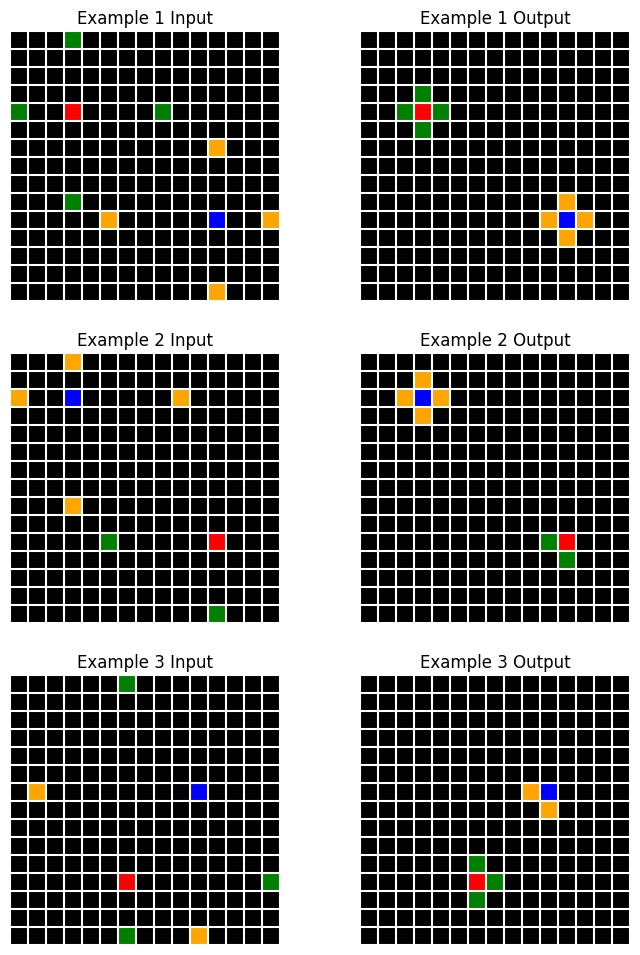

In [ ]:
#| hide
t = random.choice(train_tasks)
task = ArcTask(t)
print(f"Task: {t}\n")
task.plot()

In [ ]:
#| hide
#| eval: false
# First, generate descriptions of the task
describer = DescriptionGenerator(model, client_type='bedrock')
ds = await describer.describe_task(task, n_direct=2, n_indirect=1)
print(ds[0].d)

The input grids contain scattered colored pixels (red, green, blue, and orange) on a black background. In the output, these pixels are reorganized such that red pixels always become adjacent to green pixels, and blue pixels always become adjacent to orange pixels, forming consistent pairs. Each pixel moves the minimum distance necessary to create these pairings while maintaining approximate relative positions between different pairs on the grid.


::: {.content-hidden}

We'll construct a system prompt that tells Claude to define input and output grid models based on the task description.

:::

In [ ]:
#| export
#| eval: false
ocm = (module_dir/'ocm_cleaned.py').read_text()
sp_solve = f"""\
You are an AI assistant specializing in solving Abstraction and Reasoning Corpus (ARC) challenges. \
Each unique ARC "task" consists of example input/output grid pairs demonstrating a transformation pattern. \
For a given ARC task, the user will provide a natural language description, i.e. the properties of the grids, what objects/patterns appear in them \
and how an output grid relates to its input grid for that task. \
Your goal is to help define object-centric models for the task using the following set of primitive classes and helper functions:

<existing_primitives>
```python
{ocm.split('class CyclicPattern')[0].strip()}
```
</existing_primitives>

# Core Principles
Focus on simple, robust solutions over complex algorithms.
The default approach should be to solve tasks using ONLY the existing primitives. \
However, you may propose new primitives that would be widely applicable across various ARC tasks. \
New primitives should be proposed only when the functionality is truly fundamental and would be valuable \
across many different types of ARC tasks. You should be able to clearly justify why this functionality belongs \
as a primitive rather than in the models.

The following are NEVER valid reasons to create new primitives:
- Task-specific shape detection or creation
- One-off color transformations
- Special case handling for specific patterns
- Complex algorithms that only apply to a narrow set of tasks
- Functionality that combines multiple operations in a task-specific way
- Logic that could reasonably be implemented in the input/output models

Remember: The input and output models are where task-specific logic belongs. \
Your first instinct should always be to solve the task using existing primitives \
and encoding any special logic in the models themselves. You can use static methods if helpful.

# Response Format

<reasoning>
This is where you can break down your observations, reasoning, and alternative explanations in detail.

1. Pattern & Transformation Analysis
   - Grid properties (size, colors, background)
   - Key objects and patterns
   - Required transformations
   
2. Shape Extraction & Representation
   - How to extract objects
   - Which primitives to use
   - Edge cases to consider

3. Implementation Strategy
   - Input model approach
   - Output model logic
   - New primitive justification (if needed)

It's OK for this section to be quite long, as thorough analysis is crucial for developing a robust solution.
</reasoning>

<new_primitives>
Only if meeting all criteria above. Otherwise leave empty.
```python
# New primitive code
```
</new_primitives>

<input_model>
```python
class InputModel(Grid):
    \"\"\"Input grid model with from_array method\"\"\"
```
</input_model>

<output_model>
```python
class OutputModel(Grid):
    \"\"\"Output grid model with from_input method\"\"\"
```
</output_model>

# Key Requirements
1. Input model must fully reconstruct original array: `InputModel.from_array(arr).to_array() == arr`
2. Output model must implement transformation logic
3. Prefer simple solutions over complex algorithms

This is an iterative process. The user will feed back execution or prediction errors, if any. \
Learn from each attempt and refine your approach accordingly.\
"""

In [ ]:
#| export
@dataclass
class Solution:
    "Code components of a single ARC solution attempt."
    reasoning: str            # Reasoning process
    new_primitives: str       # Any new primitive classes defined
    input_model: str          # InputModel class code
    output_model: str         # OutputModel class code
    
    @property
    def full_code(self) -> str:
        "Concatenates the code components in the correct order."
        return f"{self.new_primitives}\n\n{self.input_model}\n\n{self.output_model}"

    @classmethod
    def from_response(cls, r: str) -> 'Solution':
        "Parse Claude's response text into a `Solution` object."
        try:
            new_prims = parse_from_xml(r, 'new_primitives')
        except (TagNotFoundError, NoContentError):
            new_prims = ''
        return cls(
            reasoning=parse_from_xml(r, 'reasoning'),
            new_primitives=new_prims,
            input_model=parse_from_xml(r, 'input_model'),
            output_model=parse_from_xml(r, 'output_model'),
        )

We use a system prompt that instructs Claude to respond with chain of thought reasoning, followed by its solution code, formatted using xml tags: <new_primitives> for proposed new OCM primitives for solving this and other ARC tasks, <input_model> for the input grid model and <output_model> for the output grid model. The `Solution` dataclass automatically parses the xml response and stores the various components.

This class will throw an exception if the xml parsing fails. We can also parse the generated code to check for syntax errors.

Before running the code, we can use `ast` to validate that it contains the correct model names, class methods etc. and doesn't raise syntax errors.

In [ ]:
#| exporti
class ValidationError(SyntaxError):
    """Custom validation error that behaves like SyntaxError for clean tracebacks"""
    pass

In [ ]:
#| export
class CodeValidator:
    """Validates that ARC solution code has required classes and methods"""
    
    @staticmethod
    def format_syntax_error(code: str, e: SyntaxError) -> str:
        """Formats a syntax error with context"""
        lineno = getattr(e, 'lineno', 1)
        lines = code.splitlines()
        
        # Show a few lines before and after the error
        start = max(0, lineno - 3)
        end = min(len(lines), lineno + 2)
        
        # Build error message with context
        msg = [f"Syntax error: {str(e)}"]
        for i in range(start, end):
            prefix = '→ ' if i + 1 == lineno else '  '
            msg.append(f"{prefix}{i + 1:4d} | {lines[i]}")
            if i + 1 == lineno and hasattr(e, 'offset') and e.offset:
                msg.append(f"       {' ' * e.offset}^")
        
        return '\n'.join(msg)
    
    @staticmethod
    def validate(code: str) -> None:
        """
        Validates ARC solution code structure.
        Raises ValidationError if requirements not met.
        """
        code = textwrap.dedent(code).strip()
        
        try:
            tree = ast.parse(code)
        except SyntaxError as e:
            msg = CodeValidator.format_syntax_error(code, e)
            raise ValidationError(msg) from None  # from None suppresses the context
            
        # Find all classes and their methods
        classes = {
            node.name: {
                'bases': [base.id for base in node.bases if isinstance(base, ast.Name)],
                'methods': {
                    n.name for n in node.body 
                    if isinstance(n, ast.FunctionDef) and 
                    any(isinstance(d, ast.Name) and d.id == 'classmethod' or
                        isinstance(d, ast.Call) and isinstance(d.func, ast.Name) and d.func.id == 'classmethod'
                        for d in n.decorator_list)
                }
            }
            for node in ast.walk(tree) 
            if isinstance(node, ast.ClassDef)
        }
        
        # Validate InputModel
        if 'InputModel' not in classes:
            raise ValidationError("Missing InputModel class")
        if 'Grid' not in classes['InputModel']['bases']:
            raise ValidationError("InputModel must inherit from Grid")
        if 'from_array' not in classes['InputModel']['methods']:
            raise ValidationError("InputModel missing @classmethod from_array")
            
        # Validate OutputModel
        if 'OutputModel' not in classes:
            raise ValidationError("Missing OutputModel class")
        if 'Grid' not in classes['OutputModel']['bases']:
            raise ValidationError("OutputModel must inherit from Grid")
        if 'from_input' not in classes['OutputModel']['methods']:
            raise ValidationError("OutputModel missing @classmethod from_input")

Let's test it out. To encourage the correct code format, we'll insert a few examples into the chat history.

In [ ]:
#| eval: false
chat = _create_chat(model, _create_client('bedrock', {}), sp=sp_solve)
for e in examples:
    chat.h.append(e.description)
    chat.h.append((f"<reasoning>\n{e.reasoning}\n</reasoning>\n\n<new_primitives>\n{e.new_primitives}\n"
                   f"</new_primitives>\n\n<input_model>\n{e.input_model}\n</input_model>\n\n"
                   f"<output_model>\n{e.output_model}\n</output_model>"))

r = await chat(
    ds[0].d,
    prefill="<reasoning>", temp=0.6, stop='</output_model>'
)
if r.stop_reason == 'stop_sequence': r.content[0].text += '</output_model>'

In [ ]:
#| eval: false
sol = Solution.from_response(r.content[0].text)
CodeValidator.validate(sol.full_code)
print(sol.input_model)

class InputModel(Grid):
    """
    Model for input grid containing scattered colored pixels.
    """
    pixel_positions: Dict[int, List[Vector]] = Field(default_factory=dict)
    
    @classmethod
    def from_array(cls, arr: np.ndarray) -> 'InputModel':
        positions = {}
        objects = []
        
        # Extract positions of each colored pixel
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                if arr[i,j] > 0:
                    color = arr[i,j]
                    if color not in positions:
                        positions[color] = []
                    pos = Vector(i=i, j=j)
                    positions[color].append(pos)
                    objects.append(Rectangle(
                        position=pos,
                        size=Vector(i=1, j=1),
                        color=Color(color)
                    ))
        
        return cls(
            size=Vector(*arr.shape),
            background_color=Color(0),
   

In fact, we can run this parsing and validating automatically and trigger retries if either fails. Let's patch a new chat method for this

In [ ]:
#| export
@patch
@delegates(AsyncChat.__call__)
async def codeloop(
    self: AsyncChat,
    pr: str,                                # Initial prompt to pass to Claude 
    max_attempts: int = 3,                  # Maximum number of retry attempts
    prefill: str = "<reasoning>",           # Text to prefill assistant's response with
    stop: str = '</output_model>',          # Stop sequence for generation
    trace_func: Optional[callable] = None,  # Function to trace attempts (e.g. print)
    **kwargs                                # Additional arguments passed to AsyncChat.__call__
) -> Solution:                              # Validated solution attempt from Claude's response
    "Generate and validate solution code from Claude, automatically retrying on validation errors"
    
    last_error = None
    for attempt in range(max_attempts):
        try:
            # Get response from Claude
            r = await self(pr, prefill=prefill, stop=stop, **kwargs)
            if r.stop_reason == 'stop_sequence': r.content[0].text += stop
                
            # Try to parse and validate the response
            solution = Solution.from_response(r.content[0].text)
            CodeValidator.validate(solution.full_code)
            
            # If we get here, validation succeeded
            if trace_func: trace_func(f"Attempt {attempt + 1}: Success")
            return solution
            
        except (TagNotFoundError, MultipleTagsError, NoContentError) as e:
            last_error = e
            error_type = e.__class__.__name__
            if trace_func: trace_func(f"Attempt {attempt + 1}: {error_type} - {str(e)}")
            # Construct retry prompt for parsing error
            pr = f"Your previous response had an XML parsing error: {error_type} - {str(e)}\nPlease try again."
            
        except ValidationError as e:
            last_error = e
            if trace_func: trace_func(f"Attempt {attempt + 1}: ValidationError - {str(e)}")
            # Construct retry prompt for code validation error
            pr = f"Your previous solution code had a validation error: {str(e)}\nPlease try again."

    # If we get here, we've exhausted our attempts
    raise RuntimeError(
        f"Failed to generate valid solution after {max_attempts} attempts. "
        f"Last error: {type(last_error).__name__} - {str(last_error)}"
    )

In [ ]:
#| exporti
class ExecutionResult:
    ...

In [ ]:
#| export
@dataclass
class Attempt:
    "An attempt at solving an ARC task."
    task: ArcTask                                            # The ARC task being solved
    description: Description                                 # Task description
    depth: int                                               # Total no. of attempts (initial attempt + retries)
    solution: Optional[Solution] = None                      # Claude-generated solution code
    chat: Optional[AsyncChat] = None                         # Claudette chat used to generate solution
    parent: Optional['Attempt'] = None                       # Previous attempt
    children: List['Attempt'] = field(default_factory=list)  # Any retries from this attempt
    result: Optional[ExecutionResult] = None                 # Result of executing the solution code
    error: Optional[str] = None                              # Error trying to generate solution code

The `Attempt` class stores everything relating to a single attempt. 
The solver will create a tree structure of attempts, with the root node being a description. Each subsequent attempt has a `parent` and a list of `children`, where a child is formed when we retry an attempt using execution/prediction error feedback. 

In [ ]:
#| hide
#| eval: false
roots = [Attempt(task=task, description=d, depth=0) for d in ds]

In [ ]:
#| exporti
async def attempt_solution(
    root: Attempt,                              # `Attempt` object containing the task and description to generate solutions for
    model: str = 'claude-3-5-sonnet-20241022',  # Model identifier (defaults to Sonnet 3.5)
    client_type: str = 'anthropic',             # 'anthropic', 'bedrock', or 'vertex'
    client_kwargs: Dict = {},                   # Optional kwargs for client instantiation
    sp: Optional[str] = None,                   # Custom system prompt (if None, uses `sp_solve`)
    temp: float = 0.7,                          # Temperature for generation (higher for diversity)
    max_attempts: int = 3,                      # Maximum attempts per description (if attempts fail xml/syntax parsing)
    **kwargs                                    # Additional arguments passed to AsyncChat.codeloop
) -> Attempt:
    "Generate a solution for a given task description"
    if sp is None: sp=sp_solve

    client = _create_client(client_type, client_kwargs)
    chat = _create_chat(model, client, sp)

    # Add examples
    random.shuffle(examples)
    for e in examples:
        chat.h.append(e.description)
        chat.h.append((f"<reasoning>\n{e.reasoning}\n</reasoning>\n\n<new_primitives>\n{e.new_primitives}\n"
                       f"</new_primitives>\n\n<input_model>\n{e.input_model}\n</input_model>\n\n"
                       f"<output_model>\n{e.output_model}\n</output_model>"))
    try:
        r = await chat.codeloop(root.description.d, temp=temp, max_attempts=max_attempts, **kwargs)
        a = Attempt(task=root.task, description=root.description, depth=1, solution=r, chat=chat, parent=root)
        root.children.append(a)
        return a
    except Exception as e:
        a = Attempt(task=root.task, description=root.description, depth=1, solution=None, chat=chat, parent=root, error=str(e))
        root.children.append(a)
        return a

In [ ]:
#| hide
#| eval: false
tsks = [attempt_solution(r, model, 'bedrock') for r in roots]
attempts = await asyncio.gather(*tsks)

Next, we need to run the generated code and make predictions on the training examples. Let's define a container for a code execution result

In [ ]:
#| export
@dataclass
class ExecutionResult:
    "Contains all results from a solution attempt execution"
    in_preds: Optional[List[ArcGrid]] = None     # from InputModel.from_array(...).to_array()
    out_preds: Optional[List[ArcGrid]] = None    # from OutputModel.from_input(...).to_array()
    error: Optional[str] = None                 # Overall code execution error
    example_errors: Optional[List[str]] = None  # Per-example errors

To generate an `ExecutionResult`, we'll run an `Attempt`'s code in a separate python process.

In [ ]:
#| export
class SandboxedExecutor:
    """Executes ARC solutions in a separate Python process with detailed results"""

    IMPORTS = """
from arcsolver.ocm import *
from pydantic import BaseModel, Field, model_validator, validator
from typing import ClassVar, List, Optional, Tuple, Union, Tuple, Literal, Dict, Set
import numpy as np
from enum import Enum
from scipy import ndimage
from collections import defaultdict
"""
    
    RUNNER_SCRIPT = """
import sys
import pickle
from arcsolver.task import ArcGrid
import traceback
import numpy as np

import linecache

def _format_error():
    exc_type, exc_value, tb = sys.exc_info()
    
    # Convert numpy values in error message to regular Python types
    if isinstance(exc_value, KeyError) and isinstance(exc_value.args[0], np.integer):
        exc_value = KeyError(int(exc_value.args[0]))
    
    lines = []
    for frame, line in traceback.walk_tb(tb):
        filename = frame.f_code.co_filename
        function = frame.f_code.co_name
        
        if filename == '<string>':  # This is our solution code
            lineno = frame.f_lineno
            source = linecache.getline('<solution>', lineno).strip()
            lines.append(f'  File "<solution>", line {{lineno}}, in {{function}}\\n    {{source}}')
    
    # Add error type and message
    lines.append(f"{{exc_type.__name__}}: {{str(exc_value)}}")
    return '\\n'.join(lines)

def run_solution():
    # Load input data efficiently from stdin
    input_data = pickle.load(sys.stdin.buffer)
    code = IMPORTS + input_data['code']
    examples = input_data['examples']  # List of (input_grid, output_grid) tuples
    
    try:
        # Set up line cache for better tracebacks
        linecache.cache['<solution>'] = (
            len(code),
            None,
            code.splitlines(keepends=True),
            '<solution>'
        )

        # Execute the solution code
        namespace = {{}}
        exec(code, namespace)
        InputModel, OutputModel = namespace['InputModel'], namespace['OutputModel']
        reconstructed_inputs, predicted_outputs = [], []
        example_errors = []
        
        for i, (input_arr, expected_arr) in enumerate(examples):
            try:
                # print(f"Processing example {{i}}", file=sys.stderr)  # Debug print
                input_model = InputModel.from_array(input_arr)
                reconstructed_input = input_model.to_array()
                reconstructed_inputs.append(ArcGrid(reconstructed_input))
            except Exception as e:
                # If an example fails, append None for its results
                reconstructed_inputs.append(None)
                predicted_outputs.append(None)
                example_errors.append(_format_error())
                continue
            try:
                output_model = OutputModel.from_input(input_model)
                prediction = output_model.to_array()
                predicted_outputs.append(ArcGrid(prediction))
                example_errors.append(None)
            except Exception as e:
                predicted_outputs.append(None)
                example_errors.append(_format_error())
        
        result = {{
            'reconstructed_inputs': reconstructed_inputs,
            'predicted_outputs': predicted_outputs,
            'example_errors': example_errors
        }}
        
    except Exception as e:
        result = {{'error': _format_error()}}
    
    # Write results efficiently to stdout
    pickle.dump(result, sys.stdout.buffer)
    sys.stdout.buffer.flush()

IMPORTS = '''{}'''

if __name__ == '__main__':
    run_solution()
""".format(IMPORTS)

    @classmethod
    def run(cls,
            sol: Solution,         # LLM-generated solution code
            task: ArcTask,         # The ARC task object
            split: str = 'train',  # 'train' or 'test'
           ) -> ExecutionResult:
        "Execute solution attempt in a separate Python process and return reconstructed inputs, predictions, and execution status"
        
        # Create runner script
        with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False) as f:
            f.write(cls.RUNNER_SCRIPT)
            runner_path = f.name
        
        try:
            # Prepare input data
            examples = task.train if split == 'train' else task.test
            input_data = {
                'code': sol.full_code,
                'examples': [(ex.input.data, ex.output.data) for ex in examples]
            }
            
            # Run solution process with pipe communication
            process = subprocess.Popen(
                ["python", runner_path],
                stdin=subprocess.PIPE,
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE
            )
            
            # Send input data through pipe
            pickle.dump(input_data, process.stdin)
            process.stdin.flush()
            
            try:
                # Wait for result with timeout
                stdout, stderr = process.communicate(timeout=5)
                
                if process.returncode == 0:
                    # Load results
                    result = pickle.loads(stdout)
                    
                    if 'error' in result:
                        return ExecutionResult(error=result['error'])
                    else:
                        return ExecutionResult(
                            in_preds=result['reconstructed_inputs'],
                            out_preds=result['predicted_outputs'],
                            example_errors=result.get('example_errors')
                        )
                else:
                    return ExecutionResult(
                        error=f"Process failed with exit code {process.returncode}\n{stderr.decode()}"
                    )
                    
            except subprocess.TimeoutExpired:
                process.kill()
                return ExecutionResult(error="Execution timed out after 5 seconds")
                
        finally:
            # Clean up runner script
            Path(runner_path).unlink()

::: {.callout-warning}
Note that we are executing code generated by AI models. While designed for research and experimentation, it includes basic safety measures:

- Code is pre-validated to check for specifically requested class names and methods.
- Code execution occurs in isolated subprocesses
- Each execution has a 5-second timeout limit
- Exceptions are caught and handled safely

Users should exercise appropriate caution and avoid running unknown solutions in security-critical environments.
:::

In [ ]:
#| hide
#| eval: false
executor = SandboxedExecutor()
res = executor.run(attempts[1].solution, attempts[1].task); res

In [ ]:
#| hide
#| eval: false
[r == t.input if r is not None else None for r, t in zip(res.in_preds, task.train)]

[True, True, True]

We can use `ProcessPoolExecutor` to run all attempts in parallel

In [ ]:
#| export
def _run_single_attempt(args):
    "Helper function to run a single attempt (must be at module level for pickling)"
    return SandboxedExecutor().run(*args)

class ConcurrentExecutor:
    "Executes multiple ARC solution attempts concurrently"
    
    def __init__(self, max_workers: Optional[int] = None):
        self.max_workers = max_workers
    
    def run_attempts(self, sols: List[Solution], task: ArcTask, split: str) -> List[ExecutionResult]:
        "Run in parallel"
        # Create list of (sol, task, split) tuples for each sol
        args = [(sol, task, split) for sol in sols]
        
        with ProcessPoolExecutor(max_workers=self.max_workers) as pool:
            # Map the run function over the arguments
            results = list(pool.map(_run_single_attempt, args))
        return results

In [ ]:
#| export
#| hide
def run_solutions(sols: List[Solution],           # List of `Solution` objects to execute
                  task: ArcTask,                  # ARC task to test against
                  split: str = 'train',           # 'train' or 'test'
                  max_workers: int | None = None  # Max concurrent processes (None defaults to CPU count)
                  ) -> List[ExecutionResult]:     # List of `ExecutionResult` objects, one per attempt
    "Executes multiple solution attempts concurrently."
    executor = ConcurrentExecutor(max_workers=max_workers)
    return executor.run_attempts(sols, task, split)

In [ ]:
#| hide
#| eval: false
results = run_solutions([a.solution for a in attempts], task)

In [ ]:
#| hide
#| eval: false
for a, r in zip(attempts, results):
    a.result = r

:::{.content-hidden}

We can patch in a score property to `Attempt`, which will calculate a score based on an `ExecutionResult`:

:::

In [ ]:
#| export
#| hide
@patch(as_prop=True)
def score(self: Attempt) -> float:
    if self.result is not None and self.result.error is None:
        in_score = sum(scores := [_score(t, p) for t, p in zip([_.input for _ in self.task.train], self.result.in_preds)])/len(scores)
        out_score = sum(scores := [_score(t, p) for t, p in zip([_.output for _ in self.task.train], self.result.out_preds)])/len(scores)

        return 0.5*in_score + 0.5*out_score
    else:
        return 0.0

In [ ]:
#| hide
#| eval: false
attempts[2].score

0.5

In [ ]:
#| hide
#| eval: false
preds = [i for i, r in enumerate(results) if r.out_preds is not None and all(r.out_preds)]; preds

[0, 1, 2, 3, 4, 6, 8, 10]

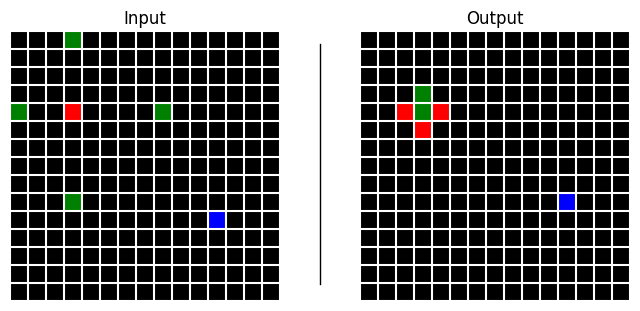

In [ ]:
#| hide
#| eval: false
ArcPair(
    results[preds[0]].in_preds[0],
    results[preds[0]].out_preds[0]
).plot()

If an attempt is unsuccessful, we can write a function to generate a prompt for Claude to try again. We'll parse a result and feed back which predictions were correct, if any and what error messages were encountered, if any.

In [ ]:
#| export
def _already_shown_task(chat_hist, task):
    for m in chat_hist:
        if isinstance(m, dict) and m['role'] == 'user':
            for d in m['content']:
                if 'source' in d.keys():
                    if d['source']['data'] == base64.b64encode(task.plot(to_base64=True)).decode("utf-8"):
                        return True
    return False

In [ ]:
#| export
def _image_message(l: list,               # list of indexes corresponding to candidate plots
                   res: ExecutionResult,  # Result of running execution
                   in_out: str,           # 'input' or 'output'
                   task: ArcTask,   # ARC task being solved
                   hist: list,      # Chat history
                  ) -> tuple[str]:  # image and message specifying what image is attached
    "Construct message describing attached image"
    idx = random.choice(range(len(l)))
    viz = ArcPair(task.train[l[idx]][0 if in_out == 'input' else 1],
                  res.in_preds[l[idx]] if in_out == 'input' else res.out_preds[l[idx]]
                 ).plot(titles=['Input' if in_out == 'input' else 'Output',
                                'Reconstructed' if in_out == 'input' else 'Predicted'], to_base64=True)

    if not _already_shown_task(hist, task): fb = "\nAttached is an image of the full task and also an image showing the true "
    else: fb = "\nAttached is an image of the true "

    
    fb += (f"{'input' if in_out == 'input' else 'output'} grid (left) and your model's "
           f"{'reconstruction' if in_out == 'input' else 'prediction'} (right) for example "
           f"{l[idx]+1}.\n")
    return viz, fb

In [ ]:
#| export
def feedback(attempt: Attempt,  # Incorrect attempt
            ) -> list:          # feedback prompt for claudette, maybe including an image of an incorrect prediction
    "Generate feedback message for Claude based on execution results"
    
    retry = ("\nPlease try again, responding in the same style as before. Use <reasoning> tags "
             "to explain your thought process for addressing these issues, then proceed "
             "with <new_primitives>, <input_model> and <output_model>.")

    res, task, chat = attempt.result, attempt.task, attempt.chat
    if res.error is not None:
        return [f"Attempting to execute your solution resulted in the following error:\n```\n{res.error}\n```\n" + retry]
    
    fb = ""
    in_correct, in_incorrect, out_correct, out_incorrect = [], [], [], []
    # Check input reconstruction
    if all(res.in_preds):
        in_matches = [r == p.input for r, p in zip(res.in_preds, task.train)]
        if all(in_matches):
            fb += "Well done, your input grid model was able to correctly reconstruct all input arrays.\n"
        else:
            in_correct = [i for i, m in enumerate(in_matches) if m]
            in_incorrect = [i for i, m in enumerate(in_matches) if not m]
            if in_correct:
                fb += (f"Your input grid model correctly reconstructed example{'s' if len(in_correct)>1 else ''} "
                       f"{', '.join(str(i+1) for i in in_correct)}.\n")
            if in_incorrect:
                fb += (f"{'However, ' if in_correct else 'Unfortunately, '} your input grid model failed "
                       f"to correctly reconstruct example{'s' if len(in_incorrect)>1 else ''} "
                       f"{', '.join(str(i+1) for i in in_incorrect)}.\n")
    else:
        errored = [i for i, r in enumerate(res.in_preds) if r is None]
        succeeded = [i for i, r in enumerate(res.in_preds) if r is not None]
        if not succeeded:
            # All examples errored
            fb += (f"Your input grid model failed to process any examples. Here's an error from example 1:\n"
                   f"```\n{res.example_errors[0]}\n```\n")
        else:
            # Mix of successes and failures
            in_correct = [i for i in succeeded if res.in_preds[i] == task.train[i].input]
            in_incorrect = [i for i in succeeded if i not in in_correct]
            if in_correct:
                fb += (f"Your input grid model correctly reconstructed example{'s' if len(in_correct)>1 else ''} "
                       f"{', '.join(str(i+1) for i in in_correct)}.\n")
            if in_incorrect:
                fb += (f"{'However, your' if in_correct else 'Your'} input grid model produced incorrect "
                       f"reconstruction{'s' if len(in_incorrect)>1 else ''} for example{'s' if len(in_incorrect)>1 else ''} "
                       f"{', '.join(str(i+1) for i in in_incorrect)}.\n")
            # Report errors
            fb += (f"Additionally, your model failed with errors on example{'s' if len(errored)>1 else ''} "
                   f"{', '.join(str(i+1) for i in errored)}. Here's the first error:\n"
                   f"```\n{next(res.example_errors[i] for i in errored)}\n```\n")

    # Check output predictions, if any
    viz = None
    if any(res.out_preds) or any(res.in_preds):  # Check if any processing happened
        # Only look at examples where input reconstruction succeeded
        in_succeeded = [i for i, r in enumerate(res.in_preds) if r is not None]
        
        if in_succeeded:
            # Among examples with successful inputs, which had successful/failed outputs
            out_succeeded = [i for i in in_succeeded if res.out_preds[i] is not None]
            out_failed = [i for i in in_succeeded if res.out_preds[i] is None]
            if out_succeeded:
                # Check correctness of successful predictions
                out_correct = [i for i in out_succeeded if res.out_preds[i] == task.train[i].output]
                out_incorrect = [i for i in out_succeeded if not res.out_preds[i] == task.train[i].output]
                if out_correct:
                    fb += (f"\nYour output model correctly predicted example{'s' if len(out_correct)>1 else ''} "
                           f"{', '.join(str(i+1) for i in out_correct)}.")
                if out_incorrect:
                    fb += (f"\n{'However,' if out_correct else 'Additionally,' if in_incorrect else 'Unfortunately,'} "
                           "your output model made incorrect "
                           f"prediction{'s' if len(out_incorrect)>1 else ''} for example{'s' if len(out_incorrect)>1 else ''} "
                           f"{', '.join(str(i+1) for i in out_incorrect)}.\n")
                    
            if out_failed:  # These are the failures in output generation where input succeeded
                fb += (f"\n{'Additionally,' if out_succeeded and out_incorrect else 'Unfortunately,'} your output model "
                       f"failed with errors on example{'s' if len(out_failed)>1 else ''} "
                       f"{', '.join(str(i+1) for i in out_failed)}. Here's the first error:\n"
                       f"```\n{res.example_errors[out_failed[0]]}\n```\n")

    # Decide which example to visualize
    if any(res.out_preds):  # At least one output was generated
        if out_correct and out_incorrect:
            # Mix of correct/incorrect outputs -> show incorrect output
            viz, msg = _image_message(out_incorrect, res, 'output', task, chat.h)
            fb += msg
        elif not out_correct:  # no correct outputs
            if all(r == task.train[i].input for i, r in enumerate(res.in_preds) if r is not None):
                # Inputs all correct -> show incorrect output
                viz, msg = _image_message(out_incorrect, res, 'output', task, chat.h)
                fb += msg
            elif in_incorrect:
                # Some inputs incorrect -> show incorrect input
                viz, msg = _image_message(in_incorrect, res, 'input', task, chat.h)
                fb += msg
    else:  # No outputs were generated
        if in_incorrect:
            # Show incorrect input if we have any
            viz, msg = _image_message(in_incorrect, res, 'input', task, chat.h)
            fb += msg

    if viz is not None: retry += ("\nIMPORTANT: Remember the core principles! Do not implement example-specific logic "
                                  "or rules based on this image.")
    if _already_shown_task(chat.h, task): return [viz, fb + retry] if viz is not None else [fb + retry]
    else: return [task.plot(to_base64=True), viz, fb + retry] if viz is not None else [fb + retry]


In [ ]:
#| eval: false
fb = feedback(attempts[0])
print(fb[0] if len(fb) == 1 else fb[-1])

Well done, your input grid model was able to correctly reconstruct all input arrays.

Unfortunately, your output model made incorrect predictions for examples 1, 2, 3.

Attached is an image of the true output grid (left) and your model's prediction (right) for example 3.

Please try again, responding in the same style as before. Use <reasoning> tags to explain your thought process for addressing these issues, then proceed with <new_primitives>, <input_model> and <output_model>.
IMPORTANT: Remember the core principles! Do not implement example-specific logic or rules based on this image.


In [ ]:
#| exporti
async def retry_solution(
    attempt: Attempt,                           # Previous (incorrect) attempt
    model: str = 'claude-3-5-sonnet-20241022',  # Model identifier (defaults to Sonnet 3.5)
    client_type: str = 'anthropic',             # 'anthropic', 'bedrock', or 'vertex'
    client_kwargs: Dict = {},                   # Optional kwargs for client instantiation
    sp: Optional[str] = None,                   # Custom system prompt (if None, uses `sp_solve`)
    prefill: str = "<reasoning>",               # Text to prefill assistant's response with
    temp: float = 0.7,                          # Temperature for generation (higher for diversity)
    max_attempts: int = 3,                      # Maximum attempts per description (if attempts fail xml/syntax parsing)
    **kwargs                                    # Additional arguments passed to AsyncChat.codeloop
) -> Attempt:
    "Retry constructing a solution based on feedback from a previous incorrect attempt"
    if sp is None: sp=sp_solve

    client = _create_client(client_type, client_kwargs)
    chat = _create_chat(model, client, sp)
    chat.h = attempt.chat.h.copy()

    fb = feedback(attempt)

    try:
        r = await chat.codeloop(
            fb, prefill=prefill, stop='</output_model>', temp=temp, max_attempts=max_attempts, **kwargs
        )
        a = Attempt(task=attempt.task, description=attempt.description, depth=attempt.depth + 1, solution=r, chat=chat, parent=attempt)
        attempt.children.append(a)
        return a
    except Exception as e:
        a = Attempt(task=attempt.task, description=attempt.description, depth=attempt.depth + 1, solution=None, chat=chat, parent=attempt, error=str(e))
        attempt.children.append(a)
        return a

In [ ]:
#| hide
#| eval: false
retry = await retry_solution(attempts[0], model, 'bedrock')

In [ ]:
#| hide
#| eval: false
executor = SandboxedExecutor()
retry.result = executor.run(retry.solution, task)

python(54015) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [ ]:
#| hide
#| eval: false
print(f"Prev attempt score: {attempts[0].score:.3f}")
print(f"Retry score: {retry.score:.3f}")

0.9785185185185186

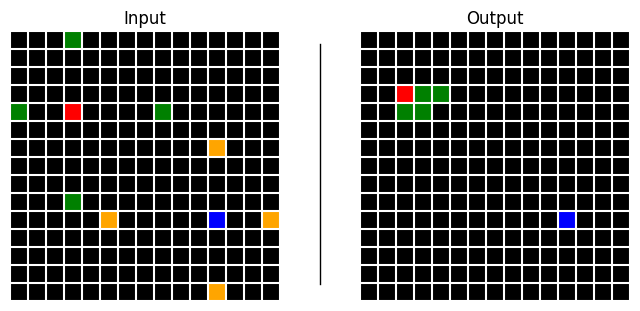

In [ ]:
#| hide
#| eval: false
ArcPair(
    retry.result.in_preds[0],
    retry.result.out_preds[0]
).plot()

In [ ]:
#| hide
#| eval: false
assert retry in retry.parent.children

In [ ]:
#| exporti
@dataclass
class SolverProgress:
    "Track progress of ARC task solution attempts"
    attempts: int              # Number of attempts so far
    budget: int                # Total attempt budget
    best_score: float          # Best score achieved so far
    n_descriptions: int        # Number of descriptions being used
    status: str                # Current solver status
    cost: float                # Total cost in USD so far
    solved: bool = False       # Whether task has been solved
    
    # def __str__(self):
    #     return (f"{self.status} | "
    #             f"Attempts: {self.attempts}/{self.budget} | "
    #             f"Best Score: {self.best_score:.3f} | "
    #             f"Cost: ${self.cost:.3f}")

In [ ]:
#| export
class ArcSolver:
    "(Attempt to) Solve an ARC task using Claude."
    def __init__(self,
                 model: str = "claude-3-5-sonnet-20241022",  # Model identifier (defaults to Sonnet 3.5)
                 client_type: str = "anthropic",             # 'anthropic', 'bedrock', or 'vertex'
                 client_kwargs: Optional[Dict] = None,       # Optional kwargs for client instantiation
                 describer: Optional[DescriptionGenerator] = None,  # Optional custom description generator
                 solve_sp: Optional[str] = None,             # Custom system prompt for solution generation
                 max_workers: Optional[int] = None,          # Max concurrent processes for execution
                 top_n: int = 2,                             # Number of best attempts to retry from
                 logger: Optional[logging.Logger] = None,    # Optional pre-configured logger
                ):
                 
        self.model = model
        self.client_type = client_type
        self.client_kwargs = client_kwargs or {}
        self.describer = (describer or DescriptionGenerator(model, client_type, client_kwargs))
        self.solve_sp = solve_sp or sp_solve
        self.max_workers = max_workers
        self.top_n = top_n
        # Set up logger if not provided
        if logger is None:
            self.logger = logging.getLogger("ArcSolver")
            if not self.logger.handlers:
                handler = logging.StreamHandler(sys.stdout)
                formatter = logging.Formatter('%(message)s')
                handler.setFormatter(formatter)
                self.logger.addHandler(handler)
                self.logger.setLevel(logging.INFO)
        else:
            self.logger = logger

    def _collect_attempts(self, root: Attempt) -> List[Attempt]:
        "Recursively collect all attempts in a tree branch."
        return [attempt for child in root.children 
                for attempt in ([child] + self._collect_attempts(child))]
    
    def _get_best_n(self, roots: List[Attempt], n: int) -> List[Attempt]:
        "Get the n best attempts across all branches of the attempt trees."
        # Collect all attempts from all roots
        all_attempts = [
            attempt for root in roots 
            for attempt in self._collect_attempts(root)
            if attempt.result is not None  # Filter out attempts without results
        ]
        # Return top n by score
        return sorted(all_attempts, key=lambda x: x.score, reverse=True)[:n]
    
    def _count_attempts(self, roots: List[Attempt]) -> int:
        "Count total number of solution attempts across all roots."
        return sum(len(self._collect_attempts(root)) for root in roots)
    
    def _log_progress(self,
                     status: str,
                     roots: List[Attempt],
                     n_attempts: int,
                     budget: int,
                     n_descriptions: int,
                     total_cost: float,
                     correct: bool = False
                    ) -> SolverProgress:
        "Log progress update and return progress object"
        all_attempts = [a for r in roots for a in self._collect_attempts(r) if a.result is not None]
        best_score = max([a.score for a in all_attempts]) if all_attempts else 0.0
        
        progress = SolverProgress(
            attempts=n_attempts,
            budget=budget,
            best_score=best_score,
            n_descriptions=n_descriptions,
            status=status,
            cost=total_cost,
            solved=correct
        )
        
        self.logger.info(
            f"{status} | "
            f"Attempts: {n_attempts}/{budget} | "
            f"Best Score: {best_score:.3f} | "
            f"Cost: ${total_cost:.3f}"
        )
        
        return progress

    async def solve(self,
                    task: ArcTask | str,           # ARC task or task ID to solve
                    d_direct: int = 1,             # Number of direct descriptions to generate
                    d_indirect: int = 1,           # Number of indirect descriptions to generate
                    budget: int = 30,              # Maximum number of solution attempts
                    temp: float = 0.7,             # Temperature for generation
                    **kwargs                       # Additional kwargs passed to attempt/retry functions
                   ) -> List[Solution]:            # Successful solutions found, if any
        "Generate and iteratively refine solutions until success or budget exhausted."
        if isinstance(task, str): task = ArcTask(task)

        self.logger.info(f"\nSolving task: {task.task_id}")
        roots, n_attempts, total_cost = [], 0, 0.0

        self._log_progress("Generating descriptions...", roots, n_attempts, 
                          budget, 0, total_cost)

        ds = await self.describer.describe_task(task, n_direct=d_direct, n_indirect=d_indirect, temp=temp)
        total_cost += sum(d.cost for d in ds)
    
        roots = [Attempt(task=task, description=d, depth=0) for d in ds]
    
        correct = []
        self._log_progress("Starting solution attempts...", roots, n_attempts,
                          budget, len(ds), total_cost)
        while n_attempts < budget:
            if n_attempts == 0:
                self._log_progress("Generating initial solutions...", 
                                roots, n_attempts, budget, len(ds), total_cost)
                attempt_tasks = [attempt_solution(r, self.model, self.client_type, self.client_kwargs, self.solve_sp) for r in roots]
            else:
                self._log_progress("Refining previous solutions...", 
                                roots, n_attempts, budget, len(ds), total_cost)
                best_n = self._get_best_n(roots, self.top_n)
                attempt_tasks = [retry_solution(a, self.model, self.client_type, self.client_kwargs) for a in best_n]
            attempts = await asyncio.gather(*attempt_tasks)
            total_cost += sum(a.chat.cost for a in attempts if a.chat is not None)
            # Filter out attempts that failed to generate valid solutions
            valid_attempts = [a for a in attempts if a.solution is not None]
            if not valid_attempts:
                self._log_progress("No valid solutions generated, retrying...", 
                                roots, n_attempts, budget, len(ds), total_cost)
                continue
    
            # Execute solutions concurrently
            self._log_progress("Testing solutions...", 
                            roots, n_attempts, budget, len(ds), total_cost)
            results = run_solutions([a.solution for a in valid_attempts],
                                    task, max_workers=self.max_workers)
            
            # Update attempts with results
            for a, r in zip(valid_attempts, results): a.result = r
            # Check for successful attemps
            if any(successful := [a for a in valid_attempts if a.score == 1.0]):
                self._log_progress("Found potential solution, validating...", 
                                roots, n_attempts, budget, len(ds), total_cost)
                test_results = run_solutions([a.solution for a in successful], task, 'test', max_workers=self.max_workers)
                for a, r in zip(successful, test_results):
                    if r.error is None and all(p == t.output for p, t in zip(r.out_preds, task.test)):
                        a.correct = True
                        correct.append(a)
    
            n_attempts = self._count_attempts(roots)
            status = ("Solution found!" if any(correct) else 
                      "Continuing refinement..." if n_attempts < budget else
                      "Budget exhausted")
            self._log_progress(status, roots, n_attempts, budget, len(ds), 
                            total_cost, bool(correct))
            if any(correct): break

        status = "Solution found! 🎉" if any(correct) else "Failed to find solution."
        self._log_progress(status, roots, n_attempts, budget, len(ds), 
                        total_cost, bool(correct))
        
        return correct

In [ ]:
show_doc(ArcSolver.solve)

---

[source](https://github.com/jackhogan/arcsolver/blob/main/arcsolver/solve.py#L818){target="_blank" style="float:right; font-size:smaller"}

### ArcSolver.solve

>      ArcSolver.solve (task:arcsolver.task.ArcTask|str, d_direct:int=1,
>                       d_indirect:int=1, budget:int=30, temp:float=0.7,
>                       show_progress:bool=True, **kwargs)

*Generate and iteratively refine solutions until success or budget exhausted.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| task | arcsolver.task.ArcTask \| str |  | ARC task or task ID to solve |
| d_direct | int | 1 | Number of direct descriptions to generate |
| d_indirect | int | 1 | Number of indirect descriptions to generate |
| budget | int | 30 | Maximum number of solution attempts |
| temp | float | 0.7 | Temperature for generation |
| show_progress | bool | True | Display solving progress bar |
| kwargs |  |  |  |
| **Returns** | **List** |  | **Successful solutions found, if any** |

Let's try it out on an example task

In [ ]:
#| hide
random.seed(42)

Task: ae3edfdc



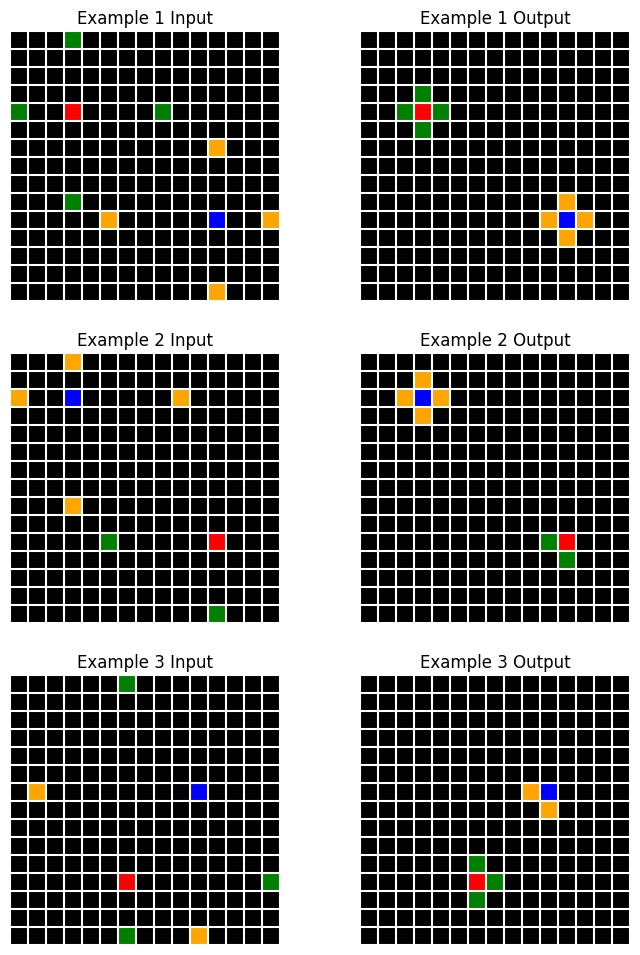

In [ ]:
t = random.choice(train_tasks)
task = ArcTask(t)
print(f"Task: {t}\n")
task.plot()

In [ ]:
#| eval: false
solver = ArcSolver(model, 'bedrock', top_n=5)
solutions = await solver.solve(task, d_direct=14, d_indirect=1, budget=50)


Solving task: ae3edfdc
Generating descriptions... | Attempts: 0/50 | Best Score: 0.000 | Cost: $0.000
Starting solution attempts... | Attempts: 0/50 | Best Score: 0.000 | Cost: $0.374
Generating initial solutions... | Attempts: 0/50 | Best Score: 0.000 | Cost: $0.374
Testing solutions... | Attempts: 0/50 | Best Score: 0.000 | Cost: $1.145
Continuing refinement... | Attempts: 15/50 | Best Score: 0.999 | Cost: $1.145
Refining previous solutions... | Attempts: 15/50 | Best Score: 0.999 | Cost: $1.145
Testing solutions... | Attempts: 15/50 | Best Score: 0.999 | Cost: $1.436
Found potential solution, validating... | Attempts: 15/50 | Best Score: 1.000 | Cost: $1.436
Solution found! | Attempts: 20/50 | Best Score: 1.000 | Cost: $1.436
Solution found! 🎉 | Attempts: 20/50 | Best Score: 1.000 | Cost: $1.436


Nice, let's have a look at the test prediction

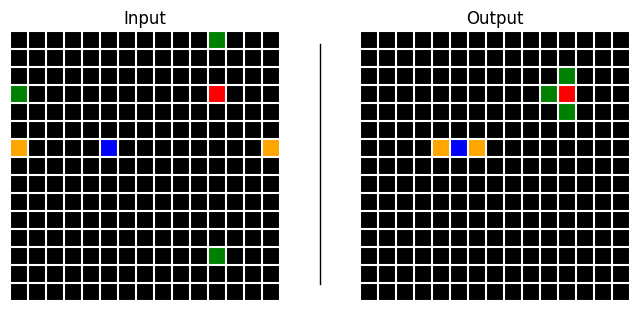

In [ ]:
#| eval: false
executor = SandboxedExecutor()
test_pred = executor.run(solutions[0].solution, task, split='test')
ArcPair(test_pred.in_preds[0], test_pred.out_preds[0]).plot()

And let's inspect the description that led to a successful solution:

In [ ]:
#| output: false
#| eval: false
print(solutions[0].description.d)

The input grids contain scattered colored pixels where red and blue pixels serve as attraction points for other colors. Green pixels are attracted to and move adjacent to red pixels, while orange pixels are attracted to and move adjacent to blue pixels. The positions of red and blue pixels remain fixed, while green and orange pixels move to become orthogonally adjacent to their respective attractors, forming clusters in the output grid. The background black color and grid dimensions remain unchanged throughout the transformation.


In [ ]:
#| echo: false
#| output: asis
#| eval: false
print(f"> {solutions[0].description.d}")

> The input grids contain scattered colored pixels where red and blue pixels serve as attraction points for other colors. Green pixels are attracted to and move adjacent to red pixels, while orange pixels are attracted to and move adjacent to blue pixels. The positions of red and blue pixels remain fixed, while green and orange pixels move to become orthogonally adjacent to their respective attractors, forming clusters in the output grid. The background black color and grid dimensions remain unchanged throughout the transformation.


Pretty good!

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()